### ***Import Library that required for this Project ❤***

---



In [26]:
import string
import re
from tensorflow import keras
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

### ***❤ Reading the data that required for this Project ❤***
here, our data is text file of the german and English sentence's pairs.

---



In [27]:
def read_text(filename):
    # open
    file = open(filename, mode='rt', encoding='utf-8')
    # read all 
    text = file.read()
    file.close()
    return text

define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

---



In [28]:
def to_lines(text):
    sent = text.strip().split('\n')
    sent = [i.split('\t') for i in sent]
    return sent

extract deu.txt directory

---



In [29]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [30]:
deu_eng = deu_eng[:50000,:]

### ***❤ Text Pre-processing that required for this Project ❤***

---



Let's take a look at our data, then we will decide which pre-processing steps to adopt.

---



In [31]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Tom is still sitting.', 'Tom sitzt noch.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2273521 (CK) & #10190706 (wolfgangth)'],
       ['Tom is still smoking.', 'Tom raucht immer noch.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2646953 (CK) & #8072723 (Luiaard)'],
       ['Tom is still talking.', 'Tom spricht noch.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2646952 (CK) & #10150806 (wolfgangth)']],
      dtype='<U537')

Remove punctuation

---

convert the lowercase

In [32]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['tom is still sitting', 'tom sitzt noch',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2273521 (CK) & #10190706 (wolfgangth)'],
       ['tom is still smoking', 'tom raucht immer noch',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2646953 (CK) & #8072723 (Luiaard)'],
       ['tom is still talking', 'tom spricht noch',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2646952 (CK) & #10150806 (wolfgangth)']],
      dtype='<U537')

 **Text** to **Sequence** Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

---



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80f1955b50>,
      dtype=object)

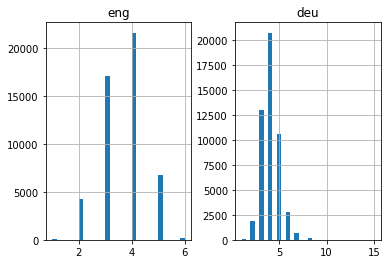

In [33]:
eng_l = []
deu_l = []
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.hist(bins = 30)

In [34]:
plt.show()

In [35]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

English Vocabulary Size: 6123
Deutch Vocabulary Size: 10081


### ***❤ Modelling the data that required for this Project ❤***

In [36]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [39]:
from tensorflow.keras import optimizers
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [45]:
filename = 'model.h1.02_03_2022'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 2.3886
Epoch 1: val_loss improved from inf to 2.35162, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 328s 5s/step - loss: 2.3886 - val_loss: 2.3516
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.2226
Epoch 2: val_loss improved from 2.35162 to 2.24659, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 314s 5s/step - loss: 2.2226 - val_loss: 2.2466
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.0829
Epoch 3: val_loss improved from 2.24659 to 2.14337, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 293s 5s/step - loss: 2.0829 - val_loss: 2.1434
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 1.9566
Epoch 4: val_loss improved from 2.14337 to 2.04657, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 292s 5s/step - loss: 1.9566 - val_loss: 2.0466
Epoch 5/30
63/63 [==============================] - ETA: 0s - loss: 1.8390
Epoch 5: val_loss improved from 2.04657 to 1.98148, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 291s 5s/step - loss: 1.8390 - val_loss: 1.9815
Epoch 6/30
63/63 [==============================] - ETA: 0s - loss: 1.7295
Epoch 6: val_loss improved from 1.98148 to 1.88682, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 292s 5s/step - loss: 1.7295 - val_loss: 1.8868
Epoch 7/30
63/63 [==============================] - ETA: 0s - loss: 1.6274
Epoch 7: val_loss improved from 1.88682 to 1.81116, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 292s 5s/step - loss: 1.6274 - val_loss: 1.8112
Epoch 8/30
63/63 [==============================] - ETA: 0s - loss: 1.5286
Epoch 8: val_loss improved from 1.81116 to 1.77048, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 293s 5s/step - loss: 1.5286 - val_loss: 1.7705
Epoch 9/30
63/63 [==============================] - ETA: 0s - loss: 1.4379
Epoch 9: val_loss improved from 1.77048 to 1.68409, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 293s 5s/step - loss: 1.4379 - val_loss: 1.6841
Epoch 10/30
63/63 [==============================] - ETA: 0s - loss: 1.3499
Epoch 10: val_loss improved from 1.68409 to 1.64904, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 292s 5s/step - loss: 1.3499 - val_loss: 1.6490
Epoch 11/30
63/63 [==============================] - ETA: 0s - loss: 1.2678
Epoch 11: val_loss improved from 1.64904 to 1.61483, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 293s 5s/step - loss: 1.2678 - val_loss: 1.6148
Epoch 12/30
63/63 [==============================] - ETA: 0s - loss: 1.1883
Epoch 12: val_loss improved from 1.61483 to 1.55164, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 293s 5s/step - loss: 1.1883 - val_loss: 1.5516
Epoch 13/30
63/63 [==============================] - ETA: 0s - loss: 1.1126
Epoch 13: val_loss improved from 1.55164 to 1.49782, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 293s 5s/step - loss: 1.1126 - val_loss: 1.4978
Epoch 14/30
63/63 [==============================] - ETA: 0s - loss: 1.0398
Epoch 14: val_loss improved from 1.49782 to 1.45463, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 296s 5s/step - loss: 1.0398 - val_loss: 1.4546
Epoch 15/30
63/63 [==============================] - ETA: 0s - loss: 0.9692
Epoch 15: val_loss improved from 1.45463 to 1.42909, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 298s 5s/step - loss: 0.9692 - val_loss: 1.4291
Epoch 16/30
63/63 [==============================] - ETA: 0s - loss: 0.9020
Epoch 16: val_loss improved from 1.42909 to 1.41703, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 296s 5s/step - loss: 0.9020 - val_loss: 1.4170
Epoch 17/30
63/63 [==============================] - ETA: 0s - loss: 0.8385
Epoch 17: val_loss improved from 1.41703 to 1.37180, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 294s 5s/step - loss: 0.8385 - val_loss: 1.3718
Epoch 18/30
63/63 [==============================] - ETA: 0s - loss: 0.7777
Epoch 18: val_loss improved from 1.37180 to 1.35192, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 294s 5s/step - loss: 0.7777 - val_loss: 1.3519
Epoch 19/30
63/63 [==============================] - ETA: 0s - loss: 0.7204
Epoch 19: val_loss improved from 1.35192 to 1.32912, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 294s 5s/step - loss: 0.7204 - val_loss: 1.3291
Epoch 20/30
63/63 [==============================] - ETA: 0s - loss: 0.6654
Epoch 20: val_loss did not improve from 1.32912
63/63 [==============================] - 280s 4s/step - loss: 0.6654 - val_loss: 1.3293
Epoch 21/30
63/63 [==============================] - ETA: 0s - loss: 0.6151
Epoch 21: val_loss improved from 1.32912 to 1.29107, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 300s 5s/step - loss: 0.6151 - val_loss: 1.2911
Epoch 22/30
63/63 [==============================] - ETA: 0s - loss: 0.5670
Epoch 22: val_loss improved from 1.29107 to 1.28745, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 296s 5s/step - loss: 0.5670 - val_loss: 1.2874
Epoch 23/30
63/63 [==============================] - ETA: 0s - loss: 0.5218
Epoch 23: val_loss improved from 1.28745 to 1.26703, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 297s 5s/step - loss: 0.5218 - val_loss: 1.2670
Epoch 24/30
63/63 [==============================] - ETA: 0s - loss: 0.4813
Epoch 24: val_loss improved from 1.26703 to 1.25957, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 296s 5s/step - loss: 0.4813 - val_loss: 1.2596
Epoch 25/30
63/63 [==============================] - ETA: 0s - loss: 0.4419
Epoch 25: val_loss did not improve from 1.25957
63/63 [==============================] - 288s 5s/step - loss: 0.4419 - val_loss: 1.2604
Epoch 26/30
63/63 [==============================] - ETA: 0s - loss: 0.4059
Epoch 26: val_loss improved from 1.25957 to 1.24044, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 300s 5s/step - loss: 0.4059 - val_loss: 1.2404
Epoch 27/30
63/63 [==============================] - ETA: 0s - loss: 0.3704
Epoch 27: val_loss did not improve from 1.24044
63/63 [==============================] - 280s 4s/step - loss: 0.3704 - val_loss: 1.2447
Epoch 28/30
63/63 [==============================] - ETA: 0s - loss: 0.3391
Epoch 28: val_loss improved from 1.24044 to 1.23842, saving model to model.h1.02_03_2022


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


INFO:tensorflow:Assets written to: model.h1.02_03_2022/assets


63/63 [==============================] - 298s 5s/step - loss: 0.3391 - val_loss: 1.2384
Epoch 29/30
63/63 [==============================] - ETA: 0s - loss: 0.3118
Epoch 29: val_loss did not improve from 1.23842
63/63 [==============================] - 280s 4s/step - loss: 0.3118 - val_loss: 1.2434
Epoch 30/30
63/63 [==============================] - ETA: 0s - loss: 0.2843
Epoch 30: val_loss did not improve from 1.23842
63/63 [==============================] - 279s 4s/step - loss: 0.2843 - val_loss: 1.2408


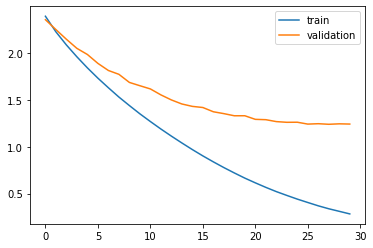

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Make Predictions

In [49]:
model = load_model('model.h1.02_03_2022')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))

In [52]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

,actual,predicted
0,weve run out of gas,we have out of gas
1,its a fad,this is a
2,tom was shaken,tom was distressed
3,this annoys me,this me
4,let me do that for you,let me do you
5,you will pay for this,youll pay for this
6,tom often cuts classes,tom often to
7,hes young and healthy,he is young angry
8,life is enjoyable,life is beautiful
9,i know it sounds silly,i know it


In [ ]:
pred_df.tail(15)

,actual,predicted
9985,tom knew the risks,tom was all of
9986,what does she do,what does you do
9987,she still loved him,she still him sing
9988,i want to be careful,i want to be boston
9989,im here arent i,im here
9990,youre a hypocrite,youre a hypocrite
9991,i gave you a book,i gave you a book
9992,lets do it,do it
9993,i broke my leg skiing,i broke my
9994,i was victorious,i was been asleep
